In [22]:
import sys
sys.path.append("../")

from src.training_utils.training import get_model_instance_segmentation
from src.training_utils.dataset import *
from src.constants import *
import PIL

In [23]:
import cv2
from PIL import Image
from IPython.display import display
import torch
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead

from torchvision import transforms as T

In [24]:
le_dict = get_encoder_dict(CLASSES_CSV)
num_classes = len(le_dict)+1 
num_classes

6

In [25]:
model = get_model_instance_segmentation(num_classes=num_classes, model_type="faster-rcnn", min_size=700)

anchor_generator = AnchorGenerator(
    sizes=tuple([(8, 16, 32, 64, 128) for _ in range(5)]),
    aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0, 3.0) for _ in range(5)]))

model.rpn.anchor_generator = anchor_generator
model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])

/home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instancing model faster-rcnn. Trainable parameters: 41532886


In [26]:
PATH_TO_LOAD_MODEL = f"/home/nacho/TFI-Cazcarra/data/models/model_best_cardinalidades_fasterrcnn.pt"

model_obj = torch.load(PATH_TO_LOAD_MODEL)
model.load_state_dict(model_obj['model_state_dict'])

<All keys matched successfully>

In [27]:
def get_class_name(num_label, le_dict):
    reversed_le_dict = {v:k for k,v in le_dict.items()}
    return reversed_le_dict[num_label]

def draw_bbox(img, xmin, ymin, xmax, ymax, score, label): 
    txt = get_class_name(label, le_dict) + ' ' + str(score)
    img = cv2.putText(img, txt, (int(xmin), int(ymin)),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255), 1)

    return cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), 
                         (255,0,0), 1)

In [28]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(700,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [29]:
test_df = pd.read_csv(f"/home/nacho/TFI-Cazcarra/data/tiles/test_cardinalidades_linux_fixed.csv")

tensor([], dtype=torch.int64)


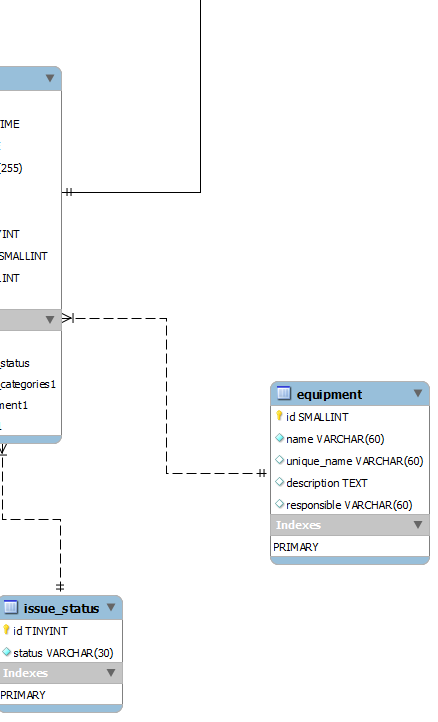

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [31]:
for test_path in test_df.image_path.unique():
    image = Image.open(test_path)
    tensor_image = T.ToTensor()(image).unsqueeze_(0)
    predictions = model(tensor_image)
    for prediction in predictions:
        print(prediction['labels'])
        for box, score, label in zip(prediction['boxes'],prediction['scores'],prediction['labels']):
            score = round(score.item(), 3)
            label = label.item()
            if score < 0.5:
                break
            xmin = box[0].item()
            ymin = box[1].item()
            xmax = box[2].item()
            ymax = box[3].item()
            print(xmin, ymin, xmax, ymax)
            if isinstance(image, PIL.Image.Image):
                image = draw_bbox(np.array(image), xmin, ymin, xmax, ymax, score, label)
            else:
                image = draw_bbox(image, xmin, ymin, xmax, ymax, score, label)
        display(Image.fromarray(image)) if not isinstance(image, PIL.Image.Image) else display(image)